# Tratando dados do jogo Stop com Pyspark

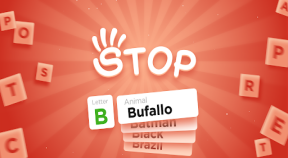

**Objetivo**: Passagem de conhecimento sobre o Spark, abordando os principais componentes e objetos para entender funcionamento do Framework.

Como exemplo prático, iremos analisar uma base simples de jogadas de stop, e iremos implementar de várias formas a validação das palavras, contagem dos pontos e por fim descobrir quem será o vencedor

**Regras**:

1. Cada jogador irá escolher uma palavra de acordo com a letra e categoria da vez. 

2. Caso a palavra seja única na rodada, o jogador ganhará 3 pontos. 

3. Caso houver mais de uma ocorrência da palavra na jogada, o jogador ganhará 1 ponto.

4. Caso a palavra seja inválida ou não for preenchida, o jogador não somará pontos.

Vence quem tiver mais pontos no fim do jogo!

## Componentes do Spark

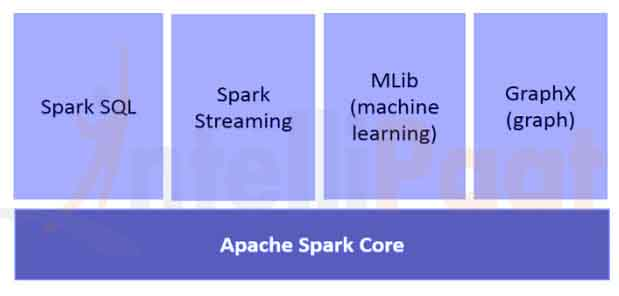

**Spark SQL**: Permite o suporte a queries SQL para efetuar as análises nos Dataframes
    
**Spark Streaming**: Usado para processar streams de dados onde houver necessidade de um processamento Real Time
    
**MLib**: Usado para processamento de modelos Machine Learning
    
**GraphX**: Voltado para o processamento de dados (comum em sistemas de recomendação)

## Arquitetura

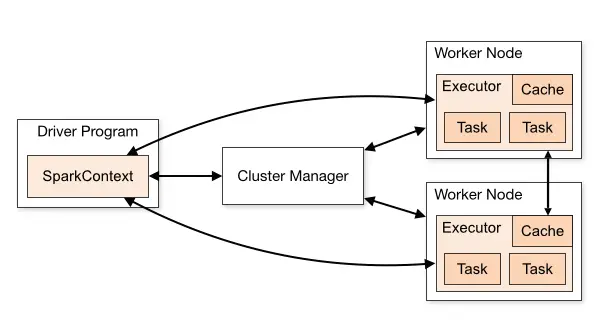

**Aplication:** Programa pelo qual é criado um objeto de contexto de execução

**Driver:** Responsável por chamar o programa principal da aplicação Spark, criar o contexto de execução, além de transcrever o código em um Job que será dividido em diversas Tasks

**ClusterManager:** Faz o trabalho da alocação de recursos para execução dos Jobs e tasks.

**Job**: Código da aplicação transcrito que será executado pelo Cluster

**Workers:** Nós ou Máquinas onde as tasks serão executadas paralelamente. No caso de uma execução local, todas essas Tasks são executadas paralelamente na JMV (Java Virtual Machine) criada pelo Spark. O paralelismo depende do número de cores do processador

**Executor**: São os serviços que rodam nos Workers, onde as Tasks são executadas

**Tasks:** Divisão do Job em partes que serão executadas em paralelo pelos Workers

## Principais Objetos

### SparkSession x SparkSession

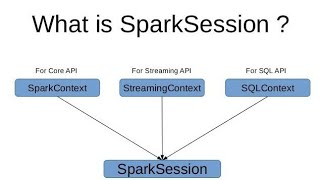

**Spark Context:** Objeto que serve como ponto de entrada de uma aplicação Spark. Com ele é possível solicitar recursos para o Cluster através do ClusterManager e para construir RDD's (Resiliente Distributed Dataset).

**Spark Session:** Boilerplate que contém um objeto SparkContext como atributo, além de outros contextos necessários para operações com Spark. Com a SparkSession, é possível manipular dados usando Spark puro, queries SQL e streamming de dados.

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [3]:
# Criando a sessão com Spark Context
sp = SparkConf().setMaster("local").setAppName("SparkGara")
sc = SparkContext(conf=sp)
spark = SparkSession(sc)

In [4]:
# encerrando a sessão atual
spark.stop()
# Criando a sessão com o builder
spark = SparkSession \
    .builder \
    .appName("SparkGara") \
    .getOrCreate()
# note que o objeto spark context foi criado automaticamente pelo builder
dir(spark)[-16:]

['builder',
 'catalog',
 'conf',
 'createDataFrame',
 'getActiveSession',
 'newSession',
 'range',
 'read',
 'readStream',
 'sparkContext',
 'sql',
 'stop',
 'streams',
 'table',
 'udf',
 'version']

## Estruturas de dados do Spark

* **RDD:** Estrutura de dados mais usada nas versões do Spark abaixo da 2.0 e é a base para as outras estruturas.

* **Dataset:** Estrutura de dados semelhante aos DataFrames Pandas. É Semelhante ao DataFrame porém é usado em linguagens compiladas como o Java.

* **Dataframe:** Estrutura de dados semelhante aos DataFrames Pandas, e é usado em linguagens como Python e R.

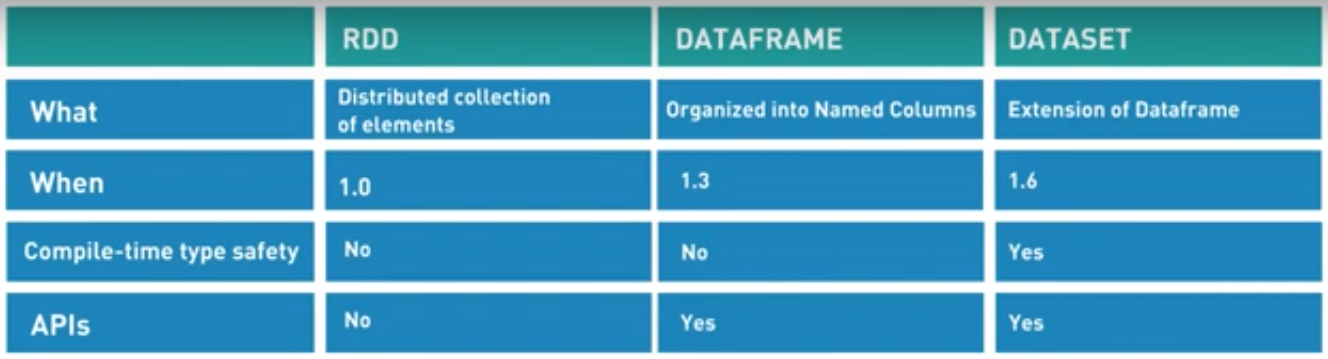

## Sobre os dados

* Letra da vez - A letra que deve ser a inicial da jogada
* Categoria - A categoria de palavra pela qual a jogada deve ser feita
* Jogador - Nome do Jogador
* Jogada - A jogada feita pelo jogador

### Objetivo:

**Criar as seguintes colunas:**

* Validacao: mostrará se a jogada feita foi validada ou não - Booleano
* Qtde Pontos: Total de pontos que o jogador acumulou durante a rodada

**Por fim somar os pontos de cada jogador para descobrir quem venceu o jogo**

In [5]:
# Lendo os dados deixando a cargo do Spark inferir o schema
df_stop = spark.read.format('csv')\
    .option('header',True)\
    .option('infer_schema',True)\
    .load('stop_data.csv')
df_stop.printSchema()
df_stop.show(5)

root
 |-- Letra_da_vez: string (nullable = true)
 |-- Categoria: string (nullable = true)
 |-- Jogador: string (nullable = true)
 |-- Jogada: string (nullable = true)

+------------+---------+-------+-------+
|Letra_da_vez|Categoria|Jogador| Jogada|
+------------+---------+-------+-------+
|           A|    Fruta| Minoru|Abacate|
|           A|    Fruta|Rodrigo|Abacaxi|
|           A|    Fruta|    Ana|Atemoia|
|           A|    Fruta|   Gabi|   Açaí|
|           A|    Fruta| Débora|Acerola|
+------------+---------+-------+-------+
only showing top 5 rows



In [6]:
# Lendo os dados escolhendo os tipos
from pyspark.sql.types import _parse_datatype_string

str_schema = "Letra_da_Vez STRING NOT NULL,Categoria STRING NOT NULL,Jogador STRING NOT NULL,Jogada STRING"

schema = _parse_datatype_string(str_schema)

df_stop = spark.read.format('csv')\
    .option('header',True)\
    .option('schema',schema)\
    .load('stop_data.csv')

df_stop.printSchema()

df_stop.show(5)

print(schema)

root
 |-- Letra_da_vez: string (nullable = true)
 |-- Categoria: string (nullable = true)
 |-- Jogador: string (nullable = true)
 |-- Jogada: string (nullable = true)

+------------+---------+-------+-------+
|Letra_da_vez|Categoria|Jogador| Jogada|
+------------+---------+-------+-------+
|           A|    Fruta| Minoru|Abacate|
|           A|    Fruta|Rodrigo|Abacaxi|
|           A|    Fruta|    Ana|Atemoia|
|           A|    Fruta|   Gabi|   Açaí|
|           A|    Fruta| Débora|Acerola|
+------------+---------+-------+-------+
only showing top 5 rows

StructType([StructField('Letra_da_Vez', StringType(), False), StructField('Categoria', StringType(), False), StructField('Jogador', StringType(), False), StructField('Jogada', StringType(), True)])


### Validando a Jogada

Iremos validar a jogada com duas abordagens: usando a função case do pyspark, e usando UDF's

In [8]:
# usando o case
from pyspark.sql.functions import when, substring, upper

df_stop.withColumn("Jogada_Valida",
                                       when(upper(substring(df_stop.Jogada,1,1)) == "A",True)
                                      .otherwise(False)
).show()

+------------+---------+-------+-------------+-------------+
|Letra_da_vez|Categoria|Jogador|       Jogada|Jogada_Valida|
+------------+---------+-------+-------------+-------------+
|           A|    Fruta| Minoru|      Abacate|         true|
|           A|    Fruta|Rodrigo|      Abacaxi|         true|
|           A|    Fruta|    Ana|      Atemoia|         true|
|           A|    Fruta|   Gabi|         Açaí|         true|
|           A|    Fruta| Débora|      Acerola|         true|
|           A|    Fruta|  Bruno|       Ameixa|         true|
|           A|    Fruta|  Paola|         null|        false|
|           A|    Fruta|Cinthya|        Amora|         true|
|           A|   Objeto| Minoru|        Ábaco|        false|
|           A|   Objeto|Rodrigo|       abajur|         true|
|           A|   Objeto|    Ana|       agulha|         true|
|           A|   Objeto|   Gabi|     alfinete|         true|
|           A|   Objeto| Débora|         null|        false|
|           A|   Objeto|

Nesta abordagem há uma falha no objeto Ábaco e no país África do Sul, pois como são acentuados, não foi validado como igual a Letra da Vez

In [34]:
# usando udf
from pyspark.sql.functions import udf, col
from pyspark.sql.types import BooleanType
from unidecode import unidecode # módulo necessário para tirar acentos

def validar_palavra(palavra, letra_da_vez):
    primeira = unidecode(str(palavra)[0]).upper()
    lv = unidecode(letra_da_vez).upper()
    return primeira == lv

validar_palavra = udf(validar_palavra,BooleanType())

In [39]:
# aplicando udf via spark puro
df_stop = df_stop.withColumn("Jogada_Validada2", validar_palavra(col("Jogada"),col("Letra_da_vez")))

Traceback (most recent call last):
  File "C:\Users\rodri\AppData\Roaming\Python\Python311\site-packages\pyspark\serializers.py", line 458, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rodri\AppData\Roaming\Python\Python311\site-packages\pyspark\cloudpickle\cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "C:\Users\rodri\AppData\Roaming\Python\Python311\site-packages\pyspark\cloudpickle\cloudpickle_fast.py", line 602, in dump
    return Pickler.dump(self, obj)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rodri\AppData\Roaming\Python\Python311\site-packages\pyspark\cloudpickle\cloudpickle_fast.py", line 692, in reducer_override
    return self._function_reduce(obj)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rodri\AppData\Roaming\Python\Python311\site-packages\pyspark\cloudpickle\cloudpickle_fast.py", line 565, in _function_reduce
    return self._dynamic_function_reduce(o

PicklingError: Could not serialize object: IndexError: tuple index out of range

In [40]:
# Aplicando udf via spark sql
spark.udf.register("validar_palavra",validar_palavra)

df_stop.registerOrReplaceTempView("stop")

df_stop = spark.sql(
"""
select *, validar_palavra(Jogada,Letra_da_vez) from stop
"""
).show()

Traceback (most recent call last):
  File "C:\Users\rodri\AppData\Roaming\Python\Python311\site-packages\pyspark\serializers.py", line 458, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rodri\AppData\Roaming\Python\Python311\site-packages\pyspark\cloudpickle\cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "C:\Users\rodri\AppData\Roaming\Python\Python311\site-packages\pyspark\cloudpickle\cloudpickle_fast.py", line 602, in dump
    return Pickler.dump(self, obj)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rodri\AppData\Roaming\Python\Python311\site-packages\pyspark\cloudpickle\cloudpickle_fast.py", line 692, in reducer_override
    return self._function_reduce(obj)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rodri\AppData\Roaming\Python\Python311\site-packages\pyspark\cloudpickle\cloudpickle_fast.py", line 565, in _function_reduce
    return self._dynamic_function_reduce(o

PicklingError: Could not serialize object: IndexError: tuple index out of range